In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pickle

import pandas as pd
import numpy as np
import sqlite3
import networkx as nx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Dribbble

In [4]:
# Connect database sqlite where the information regarding the Dribbble dataset are stored.
conn = sqlite3.connect("./preprocessing/dribbble.db", detect_types = sqlite3.PARSE_DECLTYPES)
c = conn.cursor()

In [5]:
# Read 'followers' table.
followers = pd.read_sql("SELECT id_destination, created_at AS created_at_connection, id_source FROM followers", conn)
followers.head()

,id_destination,created_at_connection,id_source
0,14275,2017-11-27 04:14:20,2005984
1,14275,2017-11-23 10:19:48,695302
2,14275,2017-11-22 16:37:55,1946520
3,14275,2017-11-19 08:50:09,1875583
4,14275,2017-11-19 04:23:46,1386566


In [6]:
# Read 'shots' table.
shots = pd.read_sql("SELECT shot_id, created_at AS created_at_shot, id_author_shot, id_team_username FROM shots", conn)
shots.head()

,shot_id,created_at_shot,id_author_shot,id_team_username
0,3549658,2017-06-07 07:01:59,1364989,NaN
1,3254544,2017-01-31 08:47:31,1364989,NaN
2,3153930,2016-12-13 10:00:26,1364989,NaN
3,3732805,2017-08-14 04:10:20,358178,NaN
4,2686725,2016-05-02 04:24:29,673130,673130.0


In [7]:
# Read 'teams' table.
teams = pd.read_sql("SELECT id_member_username, id_team_username, team_username, first_shot, last_shot FROM teams", conn)
teams.head()

,id_member_username,id_team_username,team_username,first_shot,last_shot
0,506623,938258,brandsprogram,2015-11-23 15:22:33,2016-10-03 09:15:54
1,900091,759443,hi09ui,2015-08-06 02:37:23,2016-06-18 08:16:03
2,760435,760435,100shapes,2015-02-12 11:00:06,2015-05-15 14:42:21
3,845019,845019,10Clouds,2015-05-12 10:25:27,2017-11-10 10:31:29
4,5473,5473,10up,2017-12-12 19:34:43,2017-12-12 20:35:43


In [8]:
# Create dictionary {team_id: "name"}.
id_to_name_teams = teams[["id_team_username", "team_username"]].drop_duplicates().set_index("id_team_username")["team_username"].to_dict()

In [9]:
# Read 'comments' table.
comments = pd.read_sql("SELECT comment_id, shot_id, created_at AS created_at_comment, id_author_comment, likes_count, id_author_shot FROM comments", conn)
comments.head()

,comment_id,shot_id,created_at_comment,id_author_comment,likes_count,id_author_shot
0,738715,295643,2011-10-18 12:47:15,3196,1,3196
1,3994002,1696672,2014-10-09 21:10:25,504893,1,504893
2,3994160,1696672,2014-10-10 00:07:10,504893,0,504893
3,3889476,1691148,2014-08-19 18:48:03,161795,1,161795
4,3891158,1691148,2014-08-20 13:47:06,161795,1,161795


In [10]:
# Read 'skills' table.
skills = pd.read_sql("SELECT skill, id_username FROM skills", conn)
skills.head()

,skill,id_username
0,art direction,695302
1,banking,695302
2,cryptocurrency,695302
3,design systems,695302
4,fintech,695302


In [11]:
# Read 'users' table.
users = pd.read_sql("SELECT id, username FROM users", conn)
users.head()

,id,username
0,2005984,cmaffuccio
1,695302,arestov_design
2,1946520,space307
3,1875583,Hido
4,1386566,Avagana


In [12]:
# Create dictionary {node_id: "name"}.
id_to_name_nodes = users.set_index("id")["username"].to_dict()

# Preprocessing Dribbble

## Reference period

At first, we search the teams that published at least one shot during the selected reference period. These teams will be considered as *active* and we will create a label respect to the received likes from the corresponding shots. If a team published more than one shot, we aggregated its activity into one value (mean of the received likes).

In [13]:
# Define a reference date.
START_DATE = "2017-01-01"
END_DATE = "2017-04-01"

## Team members hiring-firing

In [14]:
# Not consider when member of the team is the team itself (there exist nodes that represent team iteself).
teams = teams[(teams["id_member_username"] != teams["id_team_username"])]

# Define the hiring and firing periods of users into teams (our choice).
teams["hiring"] = teams["first_shot"]
teams["firing"] = teams["last_shot"] + pd.DateOffset(months = 12)
teams.drop(["first_shot", "last_shot"], axis = 1, inplace = True)
teams.head()

,id_member_username,id_team_username,team_username,hiring,firing
0,506623,938258,brandsprogram,2015-11-23 15:22:33,2017-10-03 09:15:54
1,900091,759443,hi09ui,2015-08-06 02:37:23,2017-06-18 08:16:03
5,14962,860812,ClassPass,2016-11-22 23:50:44,2017-11-23 00:46:11
7,4950,675289,Trello,2014-10-21 03:15:58,2018-02-15 17:40:01
11,1442131,1049573,devitemsllc,2016-10-28 16:30:28,2017-11-04 13:31:34


## Team shots publication

In [15]:
# Keep only shots published for a team.
shots_of_teams = shots[(shots["id_team_username"].notnull())]

In [16]:
len(shots_of_teams)

130816

In [17]:
# For each shot, we merge the corresponding members of the team (of all time).
shots_of_teams = pd.merge(shots_of_teams, teams, on = "id_team_username", how = "left")
shots_of_teams.head()

,shot_id,created_at_shot,id_author_shot,id_team_username,id_member_username,team_username,hiring,firing
0,2686725,2016-05-02 04:24:29,673130,673130.0,42567.0,citrusbyte,2016-01-27 19:02:45,2017-08-05 23:27:28
1,2686725,2016-05-02 04:24:29,673130,673130.0,4824.0,citrusbyte,2014-10-30 16:58:34,2018-12-13 11:30:00
2,2686725,2016-05-02 04:24:29,673130,673130.0,155464.0,citrusbyte,2016-08-05 20:07:53,2018-11-06 07:22:52
3,2686725,2016-05-02 04:24:29,673130,673130.0,73845.0,citrusbyte,2015-07-08 13:29:13,2018-10-02 23:05:04
4,2686725,2016-05-02 04:24:29,673130,673130.0,978450.0,citrusbyte,2016-08-05 21:41:51,2018-12-01 15:00:00


In [18]:
shots_of_teams.isna().sum()
# There are some shots published by teams that not have any members during their history (onl team itself).

shot_id                  0
created_at_shot          0
id_author_shot           0
id_team_username         0
id_member_username    6605
team_username         6605
hiring                6605
firing                6605
dtype: int64

In [19]:
# Keep only shots published by teams that have at least some members during the entire history.
shots_of_teams = shots_of_teams[shots_of_teams["id_member_username"].notnull()]

In [20]:
# Let's search the composition of the teams at shot publication: check what members belong to the team at shot publication.
tqdm.pandas()
shots_of_teams["published_in_team"] = shots_of_teams.progress_apply(lambda x: (x["created_at_shot"] >= x["hiring"]) & (x["created_at_shot"] < x["firing"]), axis = 1)
shots_of_teams.head()

  0%|          | 0/876479 [00:00<?, ?it/s]

,shot_id,created_at_shot,id_author_shot,id_team_username,id_member_username,team_username,hiring,firing,published_in_team
0,2686725,2016-05-02 04:24:29,673130,673130.0,42567.0,citrusbyte,2016-01-27 19:02:45,2017-08-05 23:27:28,True
1,2686725,2016-05-02 04:24:29,673130,673130.0,4824.0,citrusbyte,2014-10-30 16:58:34,2018-12-13 11:30:00,True
2,2686725,2016-05-02 04:24:29,673130,673130.0,155464.0,citrusbyte,2016-08-05 20:07:53,2018-11-06 07:22:52,False
3,2686725,2016-05-02 04:24:29,673130,673130.0,73845.0,citrusbyte,2015-07-08 13:29:13,2018-10-02 23:05:04,True
4,2686725,2016-05-02 04:24:29,673130,673130.0,978450.0,citrusbyte,2016-08-05 21:41:51,2018-12-01 15:00:00,False


In [21]:
# Keep users that belong to the team when the corresponding shot was published.
shots_of_teams = shots_of_teams[shots_of_teams["published_in_team"]]

In [22]:
# Count the number of unique members of teams for each shot and save the ids of the corresponding members.
shots_of_teams = shots_of_teams.groupby("shot_id", as_index = False).agg(size_team_at_shot_publication = ("id_member_username", lambda x: x.nunique()), 
                                                                         id_members_at_shot_publication = ("id_member_username", lambda x: x.unique().tolist()))
shots_of_teams.head()

,shot_id,size_team_at_shot_publication,id_members_at_shot_publication
0,8720,1.0,[1.0]
1,12250,1.0,[1.0]
2,38297,2.0,"[2.0, 1.0]"
3,41736,2.0,"[2.0, 1.0]"
4,49326,2.0,"[2.0, 1.0]"


In [23]:
# Add the shots that are published by team without members (the missing ones).
shots_of_teams = pd.merge(shots[(shots["id_team_username"].notnull())][["shot_id", "id_team_username", "created_at_shot"]], 
                          shots_of_teams, on = "shot_id", how = "left")
shots_of_teams.head()

,shot_id,id_team_username,created_at_shot,size_team_at_shot_publication,id_members_at_shot_publication
0,2686725,673130.0,2016-05-02 04:24:29,6.0,"[42567.0, 4824.0, 73845.0, 39618.0, 187969.0, ..."
1,2322796,673130.0,2015-10-29 20:20:28,3.0,"[4824.0, 73845.0, 39618.0]"
2,4006045,1045497.0,2017-12-08 10:35:34,2.0,"[151423.0, 741168.0]"
3,4002904,1045497.0,2017-12-07 08:37:18,2.0,"[151423.0, 741168.0]"
4,3908921,1045497.0,2017-10-30 09:29:30,2.0,"[151423.0, 741168.0]"


In [24]:
shots_of_teams.isna().sum()
# There are some shots published by teams that not have any members at shot publication.

shot_id                               0
id_team_username                      0
created_at_shot                       0
size_team_at_shot_publication     18444
id_members_at_shot_publication    18444
dtype: int64

In [25]:
# Fill the information for the team that not have any members.
shots_of_teams["size_team_at_shot_publication"] = shots_of_teams["size_team_at_shot_publication"].fillna(0).astype(int)
mask = shots_of_teams["id_members_at_shot_publication"].isna()
shots_of_teams.loc[mask, "id_members_at_shot_publication"] = pd.Series([[]]*mask.sum()).values

In [26]:
# Add the team user into the members of team.
shots_of_teams["id_members_at_shot_publication"] = shots_of_teams["id_team_username"].map(lambda x: [x]) + shots_of_teams["id_members_at_shot_publication"]
shots_of_teams["size_team_at_shot_publication"] = shots_of_teams["size_team_at_shot_publication"] + 1

In [27]:
shots_of_teams.head()

,shot_id,id_team_username,created_at_shot,size_team_at_shot_publication,id_members_at_shot_publication
0,2686725,673130.0,2016-05-02 04:24:29,7,"[673130.0, 42567.0, 4824.0, 73845.0, 39618.0, ..."
1,2322796,673130.0,2015-10-29 20:20:28,4,"[673130.0, 4824.0, 73845.0, 39618.0]"
2,4006045,1045497.0,2017-12-08 10:35:34,3,"[1045497.0, 151423.0, 741168.0]"
3,4002904,1045497.0,2017-12-07 08:37:18,3,"[1045497.0, 151423.0, 741168.0]"
4,3908921,1045497.0,2017-10-30 09:29:30,3,"[1045497.0, 151423.0, 741168.0]"


In [28]:
len(shots_of_teams)

130816

## Snapshot 

In [29]:
# Keep shots published by teams with at least a size of 4 members (also team itself).
shots_of_teams_snapshot = shots_of_teams[shots_of_teams["size_team_at_shot_publication"] > 3]
# Keep shots published during the reference period. 
shots_of_teams_snapshot = shots_of_teams_snapshot[(shots_of_teams_snapshot["created_at_shot"] >= pd.to_datetime(START_DATE)) & (shots_of_teams_snapshot["created_at_shot"] <= pd.to_datetime(END_DATE))]
shots_of_teams_snapshot

,shot_id,id_team_username,created_at_shot,size_team_at_shot_publication,id_members_at_shot_publication
56,3315339,845499.0,2017-02-23 15:21:25,12,"[845499.0, 750420.0, 1082346.0, 721524.0, 1019..."
57,3291242,845499.0,2017-02-14 13:47:14,11,"[845499.0, 750420.0, 1082346.0, 721524.0, 1019..."
58,3282401,845499.0,2017-02-10 15:20:03,11,"[845499.0, 750420.0, 1082346.0, 721524.0, 1019..."
200,3402111,1203446.0,2017-03-31 03:23:56,4,"[1203446.0, 1251030.0, 1567291.0, 1203441.0]"
201,3399255,1203446.0,2017-03-30 02:36:39,4,"[1203446.0, 1251030.0, 1567291.0, 1203441.0]"
...,...,...,...,...,...
130745,3228437,964985.0,2017-01-19 14:12:29,4,"[964985.0, 344486.0, 1071072.0, 51045.0]"
130766,3266344,964985.0,2017-02-04 17:54:22,4,"[964985.0, 344486.0, 1071072.0, 51045.0]"
130772,3229236,839306.0,2017-01-19 19:17:01,9,"[839306.0, 397380.0, 35877.0, 767099.0, 61462...."
130776,3222760,964985.0,2017-01-17 14:13:26,4,"[964985.0, 344486.0, 1071072.0, 51045.0]"


In [30]:
# Unique teams.
shots_of_teams_snapshot["id_team_username"].nunique()

769

In [31]:
# Compute an unique composition of the team during the reference period: union of the members.
composition = shots_of_teams_snapshot.groupby("id_team_username", as_index = False).agg(id_members_at_shot_publication = ("id_members_at_shot_publication", lambda x: list(x.explode().unique())), 
                                                                                        size_team_at_shot_publication = ("id_members_at_shot_publication", lambda x: x.explode().nunique()))
composition["id_team_username"] = composition["id_team_username"].astype(int)
composition.head()

,id_team_username,id_members_at_shot_publication,size_team_at_shot_publication
0,39,"[39.0, 6299.0, 7.0, 634228.0, 2.0, 35355.0, 34...",10
1,1145,"[1145.0, 79100.0, 26335.0, 1019.0, 279128.0, 8...",11
2,2933,"[2933.0, 758198.0, 812240.0, 818431.0, 454842....",7
3,3898,"[3898.0, 81880.0, 18105.0, 69122.0, 98612.0, 1...",10
4,4577,"[4577.0, 916913.0, 393146.0, 693064.0, 87059.0...",6


## Label

In [32]:
# Read shots exploration results.
shots_likes = pd.read_csv("./preprocessing/shots_likes.csv", index_col = 0)
shots_likes.head()

,shot_id,n_likes_at_1_minutes,n_likes_at_10_minutes,n_likes_at_30_minutes,n_likes_at_1_hours,n_likes_at_8_hours,n_likes_at_16_hours,n_likes_at_1_days,n_likes_at_2_days,n_likes_at_3_days,n_likes_at_5_days,n_likes_at_7_days,n_likes_at_12_days,n_likes_at_20_days,n_likes_at_30_days,n_likes_at_90_days
0,3549658,0,0,51,51,51,51,51,51,51,51,51,51,51,51,51
1,3254544,0,0,0,0,101,101,101,101,101,101,101,101,101,101,101
2,3153930,0,0,0,0,0,0,0,192,192,192,192,192,192,192,192
3,3732805,0,0,0,0,44,44,44,44,44,44,44,44,44,44,44
4,2686725,0,0,0,0,0,27,27,27,27,27,27,27,27,27,27


In [33]:
TARGET = "n_likes_at_7_days"

In [34]:
# Keep the shots that are published according to the snapshot table.
shots_likes_snapshot = pd.merge(shots_of_teams_snapshot[["shot_id", "id_team_username"]], shots_likes[["shot_id", TARGET]], 
                                on = "shot_id", how = "left")
shots_likes_snapshot.head()

,shot_id,id_team_username,n_likes_at_7_days
0,3315339,845499.0,0
1,3291242,845499.0,0
2,3282401,845499.0,744
3,3402111,1203446.0,21
4,3399255,1203446.0,26


In [35]:
def discretization_quantiles(df, y):
    # Data.
    data = df[y]
    # Compute quantiles.
    twentyfifth, seventyfifth = np.percentile(data, [33, 66])
    # Define the discretization thresholds.
    discretization_thresholds = [0, twentyfifth, seventyfifth, np.max(data)]
    # Get current discretization.
    discr = pd.cut(data, discretization_thresholds, labels = [f"Low: [0-{twentyfifth} likes]", 
                                                              f"Middle: ({twentyfifth}-{seventyfifth} likes]", 
                                                              f"High: ({seventyfifth}-{np.max(data)} likes]"], include_lowest = True)
    
    fig, ax = plt.subplots(figsize = (6, 4))
    sns.histplot(x = data.values, hue = discr.values, ax = ax, palette = "mako", discrete = True)
    ax.set_xlabel(y)

    return pd.Series(discretization_thresholds)

0       0.0
1      25.0
2      90.0
3    1984.0
dtype: float64

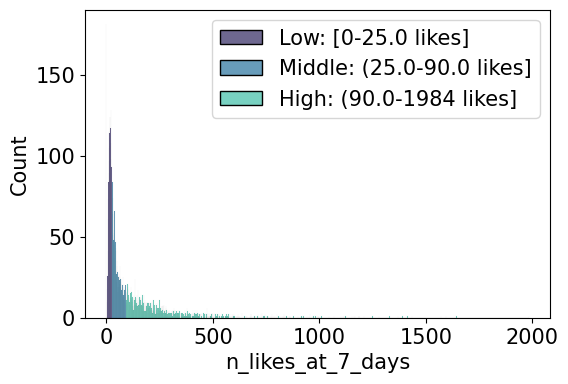

In [36]:
discretization_thresholds = discretization_quantiles(shots_likes_snapshot, y = TARGET)
discretization_thresholds

In [37]:
# Groupby the information of the teams that published more than one shot and we keep the mean as statistic.
shots_likes_snapshot_mean = shots_likes_snapshot[["id_team_username", TARGET]].groupby("id_team_username", as_index = False).mean()
shots_likes_snapshot_mean.head()

,id_team_username,n_likes_at_7_days
0,39.0,335.083333
1,1145.0,195.461538
2,2933.0,20.400000
3,3898.0,21.000000
4,4577.0,75.714286


In [38]:
n_likes_teams = shots_likes_snapshot_mean[["id_team_username", TARGET]].sort_values(by = TARGET).set_index("id_team_username")[TARGET].to_dict()

In [39]:
def discr(x, discretization_thresholds):
    return pd.cut(x, discretization_thresholds, labels = ["low", "middle", "high"], include_lowest = True)

In [40]:
# Compute performance on the basis of the discretization done using all the shots.
shots_likes_snapshot_mean["performance"] = discr(shots_likes_snapshot_mean[TARGET], discretization_thresholds)

In [41]:
# Encode.
shots_likes_snapshot_mean["performance_encode"] = shots_likes_snapshot_mean["performance"].cat.codes.astype(int)

In [42]:
shots_likes_snapshot_mean["performance_encode"].value_counts() / (len(shots_likes_snapshot_mean["performance_encode"]))

1    0.449935
0    0.331599
2    0.218466
Name: performance_encode, dtype: float64

In [43]:
# Change type.
shots_likes_snapshot_mean["id_team_username"] = shots_likes_snapshot_mean["id_team_username"].astype(int)

In [44]:
# Get dictionary of team labels.
teams_label = shots_likes_snapshot_mean.set_index("id_team_username")["performance_encode"].to_dict()

## Summary table

In [45]:
summary_teams = pd.merge(composition[["id_team_username", "id_members_at_shot_publication"]], 
                         shots_likes_snapshot_mean[["id_team_username", "performance_encode"]], 
                         on = "id_team_username", how = "left")
summary_teams.head()

,id_team_username,id_members_at_shot_publication,performance_encode
0,39,"[39.0, 6299.0, 7.0, 634228.0, 2.0, 35355.0, 34...",2
1,1145,"[1145.0, 79100.0, 26335.0, 1019.0, 279128.0, 8...",2
2,2933,"[2933.0, 758198.0, 812240.0, 818431.0, 454842....",0
3,3898,"[3898.0, 81880.0, 18105.0, 69122.0, 98612.0, 1...",0
4,4577,"[4577.0, 916913.0, 393146.0, 693064.0, 87059.0...",1


In [46]:
# Keep the users that are involved into teams.
user_teams = summary_teams["id_members_at_shot_publication"].explode().astype(int).unique()

In [47]:
len(user_teams)

5196

## Node attributes

The attributes of the nodes are computed looking at the period before the reference `START_DATE`. It is not possible to keep the attributes of the nodes before the publication of the corresponding shot because many teams may have published more than one shot and therefore it would not be possible to obtain an univocal information (i.e. a team does not correspond to a single shot publication that determines the target variable).

In [48]:
# Add author shot information.
shots_features_likes = pd.merge(shots_likes, shots[["shot_id", "id_author_shot", "created_at_shot"]], 
                                on = "shot_id", how = "left")
# Keep only the shots published by the users that belong to the selected teams.
shots_features_likes = shots_features_likes[shots_features_likes["id_author_shot"].isin(user_teams)]

In [49]:
len(shots_features_likes)

218318

In [50]:
# Select only some columns.
shots_features_likes = shots_features_likes[["shot_id", TARGET, "created_at_shot", "id_author_shot"]]

In [51]:
# Convert datetime column to appropriate type.
shots_features_likes["created_at_shot"] = pd.to_datetime(shots_features_likes["created_at_shot"])
shots_features_likes.head()

,shot_id,n_likes_at_7_days,created_at_shot,id_author_shot
4,2686725,27,2016-05-02 04:24:29,673130
5,2322796,0,2015-10-29 20:20:28,673130
276,4006112,318,2017-12-08 11:22:54,1558435
277,3947322,369,2017-11-14 13:24:46,1558435
278,3929263,294,2017-11-07 11:16:39,1558435


We decide to build the attributes of the nodes before the reference start date.

In [52]:
full_index = pd.DataFrame(user_teams, columns = ["UserId"]).set_index("UserId")

#### Features like

In [53]:
# Keep the shots that are published before 7 days from the starting reference date.
features_likes = shots_features_likes[shots_features_likes["created_at_shot"] <= pd.to_datetime(START_DATE) - pd.DateOffset(days = 7)]

In [54]:
# Compute the sum of likes received by these shots at 7 days from the corresponding shot publication.
features_likes = features_likes.groupby("id_author_shot").agg(n_likes_shot_received_before = (TARGET, "sum"))
features_likes.head()

,n_likes_shot_received_before
id_author_shot,
1,34547
2,1433
7,6661
16,4154
22,19008


#### Features shot

In [55]:
# Keep the shots published by the members of the team before the strating reference period.
features_shots = shots[(shots["id_author_shot"].isin(user_teams)) & (shots["created_at_shot"] < pd.to_datetime(START_DATE))]

In [56]:
# Count the shots published before start date.
features_shots = features_shots.groupby("id_author_shot").agg(n_shots_created_before = ("shot_id", "count"))
features_shots.head()

,n_shots_created_before
id_author_shot,
1,248
2,22
7,244
16,42
22,114


#### Features comment

In [57]:
# Convert datetime column to appropriate type.
comments["created_at_comment"] = pd.to_datetime(comments["created_at_comment"])

In [58]:
# Keep only the comments published by the users that belong to the selected teams.
comments_ref = comments[(comments["id_author_comment"].isin(user_teams)) & (comments["created_at_comment"] < pd.to_datetime(START_DATE))]

In [59]:
# Get some features.
comments_created = comments_ref.groupby("id_author_comment").agg(n_comments_created_before = ("comment_id", "count"))
comments_created.head()

,n_comments_created_before
id_author_comment,
1,3943
2,218
7,741
16,579
22,2613


In [60]:
# Get some features.
comments_received = comments_ref.groupby("id_author_shot").agg(n_comments_received_before = ("comment_id", "count"))
comments_received.head()

,n_comments_received_before
id_author_shot,
1,3943
2,218
7,741
16,579
22,2613


#### Features skill

In [61]:
# Keep only the users of the selected teams.
skills_user = skills[skills["id_username"].isin(user_teams)]

In [62]:
# Get some features.
skills_user = skills_user.groupby("id_username").agg(n_skills = ("skill", lambda x: x.nunique()))
skills_user.head()

,n_skills
id_username,
1,8
2,8
7,11
16,3
22,6


#### Features team

In [63]:
# Keep the users that belong to the selected teams and that the hiring information is before the starting reference date.
teams_ref = teams[(teams["id_member_username"].isin(user_teams)) & (teams["hiring"] < pd.to_datetime(START_DATE))]

In [64]:
# Get some features.
teams_ref = teams_ref.groupby("id_member_username").agg(n_teams_before = ("id_team_username", lambda x: x.nunique()))
teams_ref.head()

,n_teams_before
id_member_username,
1,1
2,1
7,2
16,1
22,2


### All attributes

In [65]:
# Concatenate all the features.
nodes_attribute = pd.concat([features_likes, features_shots, comments_created, 
                             comments_received, skills_user, teams_ref], axis = 1)
nodes_attribute.index.name = "UserId"
nodes_attribute = full_index.merge(nodes_attribute, left_index = True, right_index = True, how = "left")
nodes_attribute.fillna(0, inplace = True)
nodes_attribute

,n_likes_shot_received_before,n_shots_created_before,n_comments_created_before,n_comments_received_before,n_skills,n_teams_before
UserId,,,,,,
39,16722.0,74.0,2152.0,2152.0,5.0,0.0
6299,171.0,1.0,15.0,15.0,0.0,1.0
7,6661.0,244.0,741.0,741.0,11.0,2.0
634228,1068.0,2.0,238.0,238.0,4.0,1.0
2,1433.0,22.0,218.0,218.0,8.0,1.0
...,...,...,...,...,...,...
899544,208.0,6.0,56.0,56.0,7.0,0.0
1021599,78.0,2.0,4.0,4.0,2.0,0.0
117798,752.0,22.0,38.0,38.0,0.0,2.0


In [66]:
summary_teams

,id_team_username,id_members_at_shot_publication,performance_encode
0,39,"[39.0, 6299.0, 7.0, 634228.0, 2.0, 35355.0, 34...",2
1,1145,"[1145.0, 79100.0, 26335.0, 1019.0, 279128.0, 8...",2
2,2933,"[2933.0, 758198.0, 812240.0, 818431.0, 454842....",0
3,3898,"[3898.0, 81880.0, 18105.0, 69122.0, 98612.0, 1...",0
4,4577,"[4577.0, 916913.0, 393146.0, 693064.0, 87059.0...",1
...,...,...,...
764,1610641,"[1610641.0, 1610109.0, 1485520.0, 1111907.0]",1
765,1612409,"[1612409.0, 1094839.0, 1534189.0, 1352156.0, 1...",1
766,1612904,"[1612904.0, 361222.0, 351.0, 79356.0]",0
767,1631649,"[1631649.0, 456167.0, 337485.0, 1631689.0, 811...",1


In [67]:
# Compute team composition in order to insert team information into node attributes table.
composition = summary_teams.explode("id_members_at_shot_publication")
composition["id_members_at_shot_publication"] = composition["id_members_at_shot_publication"].astype(int)
composition = composition.groupby("id_members_at_shot_publication").apply(lambda x: list(x["id_team_username"])).to_dict()

In [68]:
# Add team information.
nodes_attribute = nodes_attribute.join(pd.Series(composition, name = "TeamId"), how = "left").explode("TeamId")
nodes_attribute.set_index("TeamId", append = True, inplace = True)
nodes_attribute

,,n_likes_shot_received_before,n_shots_created_before,n_comments_created_before,n_comments_received_before,n_skills,n_teams_before
UserId,TeamId,,,,,,
39,39,16722.0,74.0,2152.0,2152.0,5.0,0.0
6299,39,171.0,1.0,15.0,15.0,0.0,1.0
7,39,6661.0,244.0,741.0,741.0,11.0,2.0
634228,39,1068.0,2.0,238.0,238.0,4.0,1.0
2,39,1433.0,22.0,218.0,218.0,8.0,1.0
...,...,...,...,...,...,...,...
899544,1655329,208.0,6.0,56.0,56.0,7.0,0.0
1021599,1655329,78.0,2.0,4.0,4.0,2.0,0.0
117798,1655329,752.0,22.0,38.0,38.0,0.0,2.0


## Graph

In [69]:
# Keep connections util the end of the reference date.
edges = followers[(followers["created_at_connection"] <= pd.to_datetime(END_DATE))][["id_source", "id_destination"]]
edges.head()

,id_source,id_destination
51,1009428,14275
52,1293188,14275
53,4478,14275
54,1652758,14275
55,1647122,14275


In [70]:
len(edges)

18328589

In [71]:
# Search for the edges that linked two users that are involved into teams.
edges_teams_bool = edges["id_source"].isin(user_teams) & edges["id_destination"].isin(user_teams)

In [72]:
edges_teams = edges[edges_teams_bool]
edges_teams.head()

,id_source,id_destination
53,4478,14275
62,339297,14275
80,25830,14275
94,244573,14275
101,312581,14275


In [73]:
len(edges_teams)

304315

In [74]:
check_double_edge = edges_teams.apply(lambda x: str(sorted([x["id_source"], x["id_destination"]])), axis = 1)
check_double_edge.duplicated().sum()

32223

In [75]:
# Example.
src, dst = edges_teams.loc[check_double_edge.duplicated()[check_double_edge.duplicated()].index[0]]

edges_teams[(edges_teams["id_source"].isin([src, dst])) & (edges_teams["id_destination"].isin([src, dst]))]

,id_source,id_destination
5592,227911,194964
10146,194964,227911


In [76]:
e = edges_teams.apply(tuple, axis = 1)

In [77]:
# Create networkx graph.
G = nx.DiGraph()
G.add_nodes_from(user_teams)
G.add_edges_from(e.values) 

In [78]:
G.number_of_nodes()

5196

## Relabeling team ids

In [79]:
# Create a new id for the team.
summary_teams["team_recoded"] = range(len(summary_teams))
# Save mapping from old ids to new ids.
mapping_teams = summary_teams[["id_team_username", "team_recoded"]].set_index("id_team_username")["team_recoded"].to_dict()

In [80]:
# Create dictionary information from new team_id to original name.
teams_name = {v: id_to_name_teams[k] for k,v in mapping_teams.items()}
# Relabel team ids into label dictionary.
teams_label = {v: teams_label[k] for k,v in mapping_teams.items()}
n_likes_teams = {v: n_likes_teams[k] for k,v in mapping_teams.items()}

In [81]:
nodes_attribute.reset_index(inplace = True)
nodes_attribute["TeamId"] = nodes_attribute["TeamId"].map(mapping_teams)

# Construct the team composition: {node_id: [team_id]}.
team_composition = nodes_attribute.groupby("UserId", as_index = True).agg(teams = ("TeamId", lambda x: x.unique().tolist()))
team_composition = team_composition["teams"].to_dict()

nodes_attribute.set_index(["UserId", "TeamId"], inplace = True)

In [82]:
nx.set_node_attributes(G, team_composition, "Team")  

## Relabeling node ids

In [83]:
# Relabel nodes.
G = nx.convert_node_labels_to_integers(G, first_label = 0, label_attribute = "old_ids")

In [84]:
mapping_nodes = nx.get_node_attributes(G, "old_ids")

In [85]:
def inverse_mapping(f):
    return f.__class__(map(reversed, f.items()))

In [86]:
# Mapping the node id into new ones.
nodes_attribute.reset_index(inplace = True)
nodes_attribute["UserId"] = nodes_attribute["UserId"].map(inverse_mapping(mapping_nodes))
nodes_attribute.set_index(["UserId", "TeamId"], inplace = True)
nodes_attribute.sort_index(inplace = True)
nodes_attribute.index.names = ["node", "team"]

In [88]:
# Get dictionary from new node id to original node name.
nodes_name = {v: id_to_name_nodes[k] for k, v in inverse_mapping(mapping_nodes).items()}

## Output data

In [89]:
# Save Networkx graph.
with open("./data/graph.pkl", "wb") as f:
    pickle.dump(nx.readwrite.json_graph.node_link_data(G), f)

# Save teams label.
with open("./data/teams_label.pkl", "wb") as out:
    pickle.dump(teams_label, out)
    
# Save node attributes.
with open("./data/nodes_attribute.pkl", "wb") as f:
    pickle.dump(nodes_attribute, f)
    
# Save node names.
with open("./data/nodes_name.pkl", "wb") as out:
    pickle.dump(nodes_name, out)
    
# Save node names.
with open("./data/teams_name.pkl", "wb") as out:
    pickle.dump(teams_name, out)
    
# Save teams continuous label.
with open("./data/teams_continuous_label.pkl", "wb") as out:
    pickle.dump(n_likes_teams, out)